In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


**Get Data**

In [2]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='latin-1')

# **Formatting YYYYMM**

1. Take datetime data, only the month and year
2. Count the year to make format YYYYMM

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df['cohort'] = df['InvoiceDate'].dt.strftime('%Y%m').astype(int)

# **Make New Dataframe**

To make a cohort plot, going to use Customer ID and Invoice Date, each month.

In [4]:
df_first = df.groupby('CustomerID')['cohort'].min().reset_index() #take the earliest invoice date
df_first.columns = ['CustomerID', 'first_cohort'] 

# Merge the first purchase cohort with the original DataFrame
df = df.merge(df_first, on='CustomerID')

In [5]:
headers = df['cohort'].value_counts().reset_index()
headers.columns = ['Cohorts', 'Count']
headers = headers.sort_values(['Cohorts'])['Cohorts'].to_list()

In [6]:
# Create cohort distance column
df['cohort_distance'] = df['cohort'] - df['first_cohort']

In [7]:
df.dropna(inplace=True)

In [8]:
df['cohort_distance'] = df.apply(lambda row: (headers.index(row['cohort']) - headers.index(row['first_cohort'])) if (row['first_cohort'] != 0 and row['cohort'] != 0) else np.nan, axis=1)

In [9]:
# Pivot the data to count transactions made by CustomerID for each cohort and cohort distance
cohort_table = df.pivot_table(index='first_cohort', columns='cohort_distance', values='CustomerID', aggfunc='count')

# Display the cohort table
print(cohort_table)

cohort_distance       0        1       2        3        4        5        6   \
first_cohort                                                                    
201012           26850.0  10881.0  9183.0  12111.0  10092.0  12622.0  11829.0   
201101           11031.0   2392.0  3072.0   2371.0   3824.0   3307.0   2880.0   
201102            8788.0   1488.0  1937.0   2442.0   2218.0   2056.0   2205.0   
201103           11151.0   1478.0  2498.0   2378.0   2436.0   2125.0   2797.0   
201104            7320.0   1435.0  1329.0   1299.0   1395.0   2088.0   1935.0   
201105            6087.0   1123.0   890.0    920.0   1494.0   2345.0   1946.0   
201106            5652.0    939.0   733.0   1513.0   1723.0   2504.0    622.0   
201107            5024.0    525.0  1353.0   1387.0   1839.0    529.0      NaN   
201108            4822.0   1608.0  2872.0   2780.0    905.0      NaN      NaN   
201109            8343.0   2483.0  2719.0    874.0      NaN      NaN      NaN   
201110           11878.0   3

# **Visualization with Heatmap Seaborn**

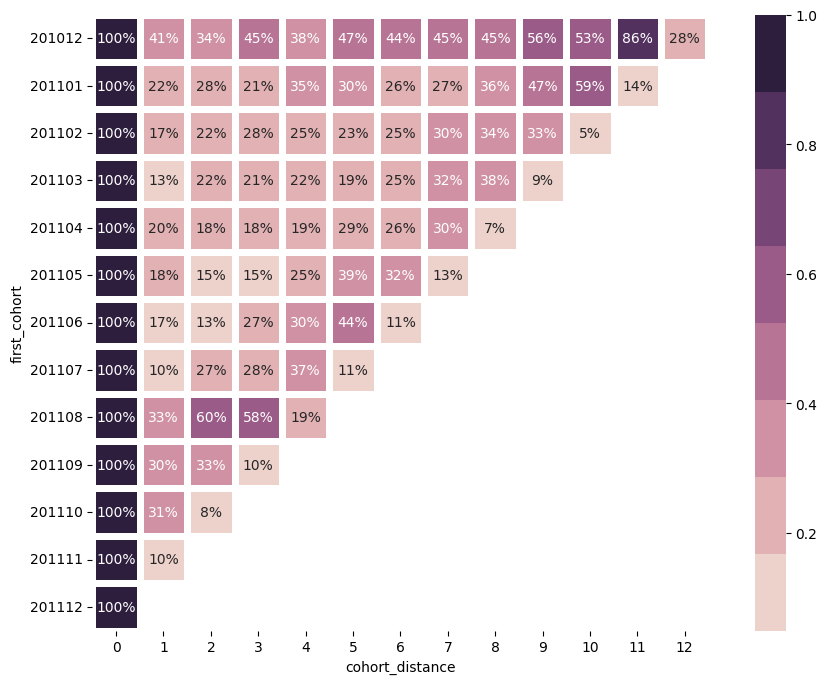

In [10]:
# Normalization
cohort_pivot = cohort_table.div(cohort_table[0], axis=0)

import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', mask=cohort_pivot.isnull(), ax=ax, square=True, linewidth=5, cmap=sns.cubehelix_palette(8))
plt.show()